# NIRCam LW data analysis I. Finding calibrated data

In this notebook, we will produce corrected data from `uncal` JWST data.

For stage 1 processing, we will mainly use the `jwst` pipeline with some modifications. The main modification is the use of `refpix` step. Although this dataset _have_ reference pixels on three edges of the detector, some earlier works with ERS data have shown that background subtraction at group level works more efficiently than when it is done at integration level. Therefore, we will perform a group level background subtraction using ROEBA (row-by-row odd/even by amplifier correction, [Schlawin et al. 2023](https://iopscience.iop.org/article/10.1088/1538-3873/aca718)) algorithm in addition to the `refpix` step (see, below). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from tqdm import tqdm
import os
import utils
from stark import reduce

In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/Data/NRC_LW'
pout = p1 + '/NRCLW/Outputs/Tests'

fname = 'jw01366002001_04103_00001-seg004_nrcalong_uncal.fits'

## calwebb detector 1 processing

In [3]:
uncal = datamodels.RampModel(pin + '/' + fname)
nint = np.random.randint(0, uncal.data.shape[0])

print(uncal)

<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrcalong_uncal.fits>


Meaning that the data has 9 total integration and 12 groups per integrations. An individual frame has 256 by 2048 pixels (256 rows and 2048 columns). Let's first visualise the data.

Text(0.5, 1.0, 'Example data')

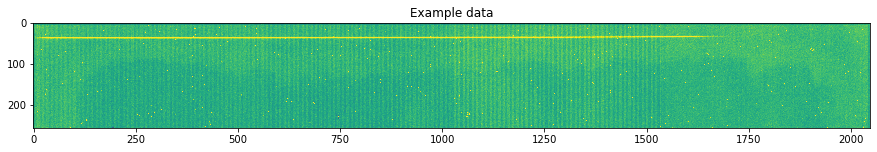

In [4]:
plt.figure(figsize=(15,5))
im = plt.imshow(uncal.data[nint,-1,:,:], interpolation='none')
im.set_clim([0,2e4])
plt.title('Example data')

Let's perform `groupscale`, `dq`, `saturation` and `superbias` steps manually.

In [5]:
"""det1 = calwebb_detector1.Detector1Pipeline.call(uncal,\
                                                steps={'jump' : {'rejection_threshold' : 20., 'maximum_cores': 'all'},\
                                                       'dark_current' : {'skip' : True},\
                                                       'ramp_fit' : {'maximum_cores' : 'all'}},\
                                                output_dir=pout, save_results=True)"""

# I tried running the pipeline collectively, but it turns out that the jump step was flagging many pixels
# wrongly; maybe this is because of improper reference pixel correction step -- so now, I will manually perform
# this step using ROEBA algorithm.

groupscale_results = calwebb_detector1.group_scale_step.GroupScaleStep.call(uncal, save_results=False)
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call(groupscale_results, save_results=False)
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results, save_results=False)
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(saturation_results, save_results=False)

2023-10-24 20:06:05,609 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2023-10-24 20:06:05,678 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrcalong_uncal.fits>,).
2023-10-24 20:06:05,680 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-10-24 20:06:05,942 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2023-10-24 20:06:05,943 - stpipe.GroupScaleStep - INFO - Step will be skipped
2023-10-24 20:06:05,947 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done
2023-10-24 20:06:05,967 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-10-24 20:06:06,036 -

Let's look at the counts in one of the rows,

Text(0.5, 1.0, 'Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

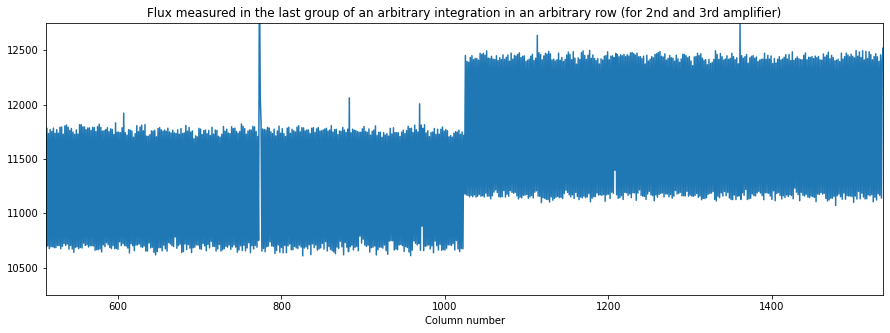

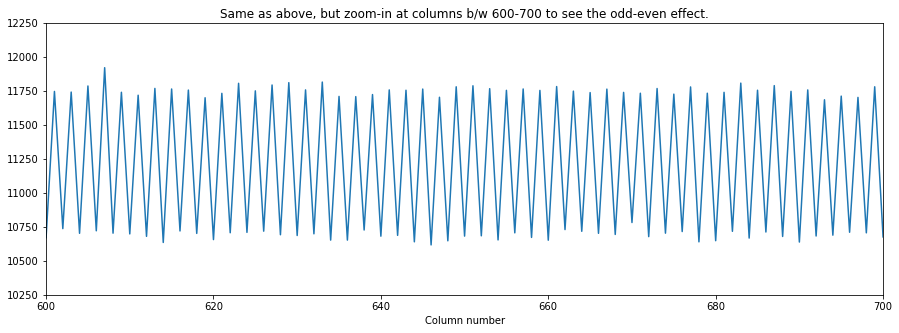

In [6]:
plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,100,:])
plt.ylim([10250,12750])
plt.xlim([512,1536])
plt.xlabel('Column number')
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,100,:])
plt.ylim([10250,12250])
plt.xlim([600,700])
plt.xlabel('Column number')
plt.title('Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

That's a lot of noise (both odd-even effect noise and offset noise coming from not subtracting background).

Let's see if reference pixel correction step can improve upon this.

In [7]:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results, save_results=False)

2023-10-24 20:06:13,016 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2023-10-24 20:06:13,097 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrcalong_uncal.fits>,).
2023-10-24 20:06:13,099 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2023-10-24 20:06:13,371 - stpipe.RefPixStep - INFO - NIR subarray data
2023-10-24 20:06:13,374 - stpipe.RefPixStep - INFO - 4 readout amplifiers used
2023-10-24 20:06:13,375 - stpipe.RefPixStep - INFO - The following parameters are valid for this mode:
2023-10-24 20:06:13,376 

And, did it properly correct for odd-even noise?

Text(0.5, 1.0, 'Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

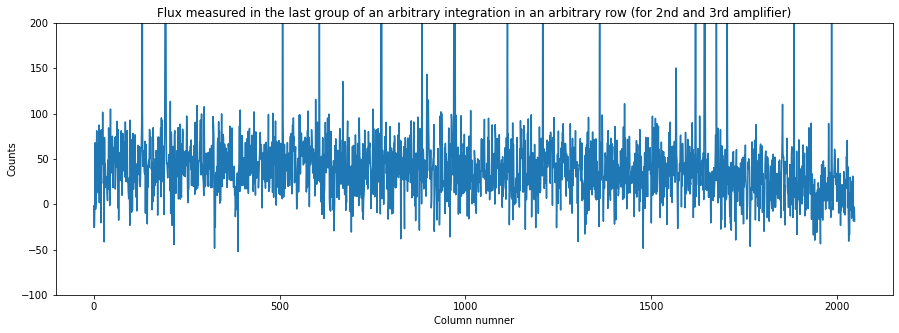

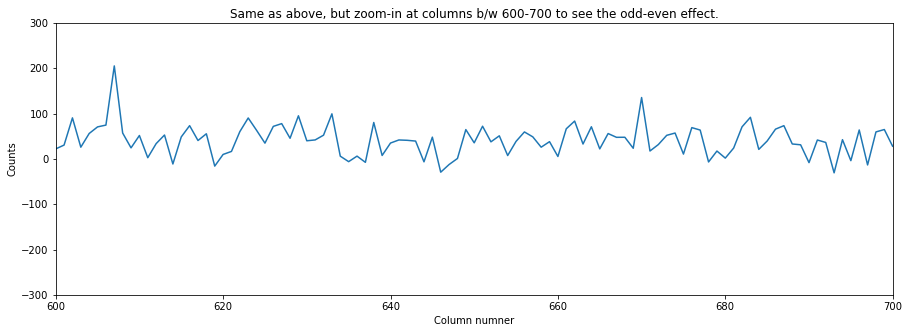

In [8]:
plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,100,:])
plt.ylim([-100,200])
#plt.xlim([512,1536])
plt.xlabel('Column numner')
plt.ylabel('Counts')
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,100,:])
plt.ylim([-300,300])
plt.xlim([600,700])
plt.xlabel('Column numner')
plt.ylabel('Counts')
plt.title('Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

Looks like most of the odd-even noise is corrected -- however, it seems that background subtraction was not performed properly in the sense that the background level in above data doesn't seem to be correct. So, let' still perform ROEBA background subtraction.

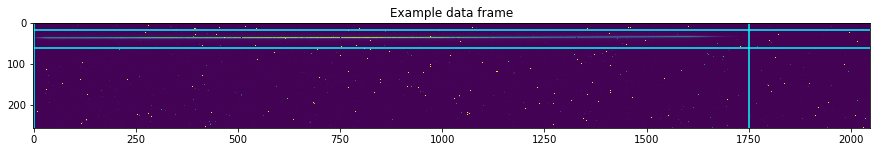

Text(0.5, 1.0, 'Mask (M2)')

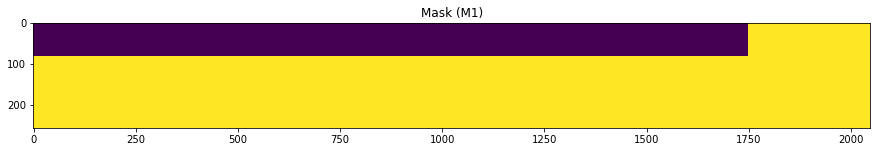

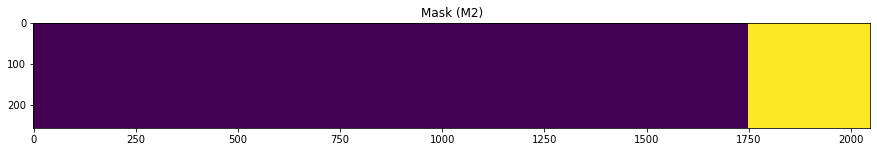

In [9]:
plt.figure(figsize=(15,5))
im = plt.imshow(refpix_results.data[nint,-1,:,:], interpolation='none')
im.set_clim([-100,2e4])
plt.axvline(0, color='cyan')
plt.axvline(1750, color='cyan')
plt.axhline(15, color='cyan')
plt.axhline(60, color='cyan')
plt.title('Example data frame')
plt.show()

m1 = np.ones(refpix_results.data[nint,-1,:,:].shape)
m1[0:80,0:1750] = 0.

m2 = np.ones(refpix_results.data[nint,-1,:,:].shape)
m2[:,0:1750] = 0.

plt.figure(figsize=(15,5))
plt.imshow(m1, interpolation='none')
plt.title('Mask (M1)')

plt.figure(figsize=(15,5))
plt.imshow(m2, interpolation='none')
plt.title('Mask (M2)')

Okay, so now we will use these mask regions to perform ROEBA-based background subtraction. Basically, we will separately perform background subtraction for each amplifier (there are 4 of them in the detector, each with 512 columns). First we will estimate background for even and odd columns separately and subtract the estimated background from even and odd columns, respectively (background pixels are marked with yellow is M1 mask above). While this will take care of any residual odd-even effect, this will not properly perform a background subtraction. So, in addition to this, we will once again perform column-by-column background subtraction using the same background pixels (yellow in M1 mask). The subtracted background is simply a median of background pixels in a given column.


In the end we perform a row-by-row background subtraction --  a same correction for _all_ amplifier since in first three amplifiers there are several rows in mask for which we don't have "background" rows (see, mask M2 in which background pixels are marked with yellow). In this latter step, we simply compute median of the row to find the background.

The algorithm that we will use here is a modified version of what is presented in [Schlawin et al. 2023](https://iopscience.iop.org/article/10.1088/1538-3873/aca718).

In [10]:
# Computing ROEBA background subtraction on _group_ level
for integration in tqdm(range(refpix_results.data.shape[0])):
    for group in range(refpix_results.data.shape[1]):
        refpix_results.data[integration, group, :, :] = \
            utils.roeba_backgroud_sub(refpix_results.data[integration, group, :, :], m1, fast_read=False)
        # Slow-read (i.e., along the columns) additional correction
        dummy_data = np.copy(refpix_results.data[integration, group, :, :])
        dummy_data[m1 == 0.] = np.nan
        refpix_results.data[integration, group, :, :] = \
            refpix_results.data[integration, group, :, :] - np.nanmedian(dummy_data, axis=0)[None,:]
        # Fast read correction (i.e., along the rows) for all amplifiers
        dummy_data = np.copy(refpix_results.data[integration, group, :, :])
        dummy_data[m2 == 0.] = np.nan
        refpix_results.data[integration, group, :, :] = \
            refpix_results.data[integration, group, :, :] - np.nanmedian(dummy_data, axis=1)[:,None]

100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


Text(0, 0.5, 'Counts')

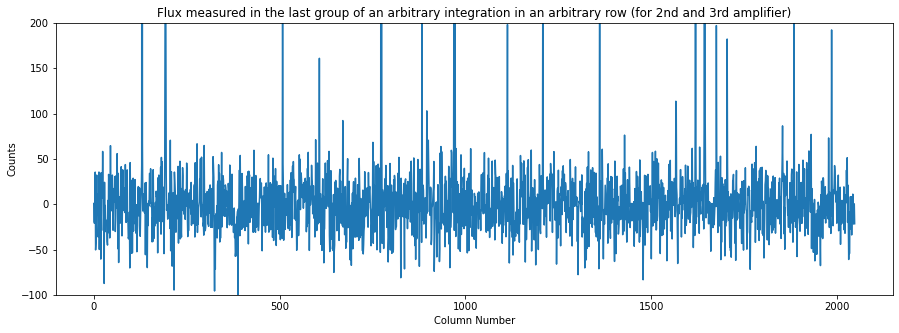

In [11]:
plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,100,:])
plt.ylim([-100,200])
#plt.xlim([512,1536])
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')
plt.xlabel('Column Number')
plt.ylabel('Counts')

Awesome! Not only we took care of odd-even noise, but also performed efficient background correction!

Now again continuing with the rest of the steps from the pipeline.

In [12]:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(refpix_results,
                                                                        save_results=False)
darkcurrent_results = calwebb_detector1.dark_current_step.DarkCurrentStep.call(linearity_results,
                                                                            save_results=False)
jumpstep_results = calwebb_detector1.jump_step.JumpStep.call(darkcurrent_results, rejection_threshold=30.,\
                                                             maximum_cores='all', save_results=False)
rampfitting_results = calwebb_detector1.ramp_fit_step.RampFitStep.call(jumpstep_results, maximum_cores='all',\
                                                                       save_results=False)
gainscale_results = calwebb_detector1.gain_scale_step.GainScaleStep.call(rampfitting_results[1],\
                                                                         output_dir=pout, save_results=True)

2023-10-24 20:06:38,442 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-10-24 20:06:38,525 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(9, 12, 256, 2048) from jw01366002001_04103_00001-seg004_nrcalong_uncal.fits>,).
2023-10-24 20:06:38,527 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-10-24 20:06:38,567 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/japa6985/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0052.fits
2023-10-24 20:06:38,789 - stpipe.LinearityStep - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2023-10-24 20:06:38,790 - stpipe.LinearityStep - WARNING - Keyword

Let's look at the mask:

Total per cent of masked points: 5.0361 %


Text(0.5, 1.0, 'Bad-pixels for an arbitrary integration')

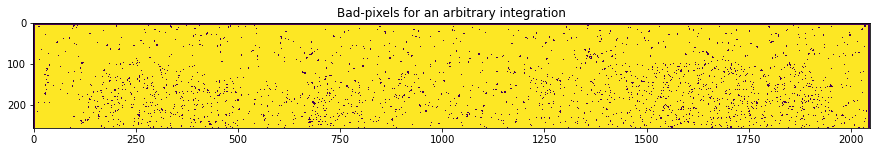

In [13]:
dq = rampfitting_results[1].dq
mask = np.ones(dq.shape)
mask[dq > 0] = 0.

print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask) / (mask.shape[0] * mask.shape[1] * mask.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask[nint,:,:], interpolation='none')
plt.title('Bad-pixels for an arbitrary integration')
#plt.xlim([512,1536])

Okay, so there are less than 1% of pixels masked as "bad" -- not a huge number.

And this is how the data looks like,

Text(0.5, 1.0, 'Example data frame')

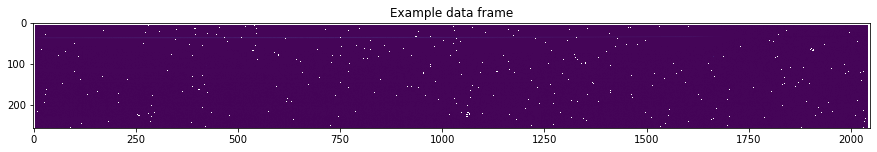

In [14]:
plt.figure(figsize=(15,5))
plt.imshow(gainscale_results.data[nint,:,:], interpolation='none')
plt.title('Example data frame')

Text(0.5, 1.0, 'Flux level in an arbitrary row of an arbitrary integration')

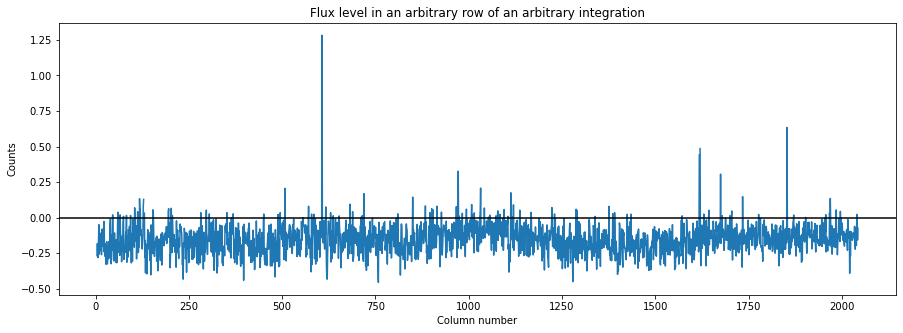

In [15]:
plt.figure(figsize=(15,5))
plt.plot(gainscale_results.data[nint,100,:])
#plt.axvline(1536, color='k')
plt.axhline(0., color='k')
plt.xlabel('Column number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary row of an arbitrary integration')

Text(0.5, 1.0, 'Flux level in an arbitrary column of an arbitrary integration')

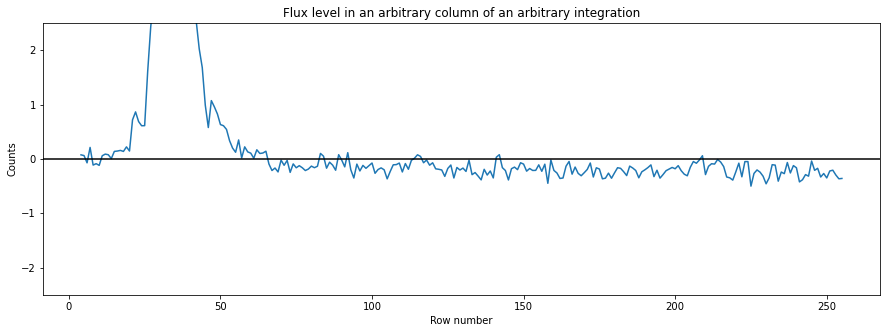

In [16]:
plt.figure(figsize=(15,5))
plt.plot(gainscale_results.data[nint,:,500])
plt.ylim([-2.5,2.5])
plt.axhline(0., color='k')
plt.xlabel('Row number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary column of an arbitrary integration')

Okay, so most of all odd-even effect and amplifier effect were removed effectively. However, I see that the count level in a background row (see, above figure) is slightly below zero, meaning that we need an additional row-by-row background correction which we will perform after "correcting" the data.

And, finally, correct the data. Starting with correcting the errorbars,

In [17]:
times_bjd = uncal.int_times['int_mid_BJD_TDB']

print('>>>> --- Correcting errorbars (for zeros and NaNs)...')
## Correct errorbars
med_err = np.nanmedian(gainscale_results.err.flatten())
## Changing Nan's and zeros in error array with median error
corr_err1 = np.copy(gainscale_results.err)
corr_err2 = np.where(gainscale_results.err != 0., corr_err1, med_err)                     # Replacing error == 0 with median error
corrected_errs = np.where(np.isnan(gainscale_results.err) != True, corr_err2, med_err)    # Replacing error == Nan with median error
print('>>>> --- Done!!')

>>>> --- Correcting errorbars (for zeros and NaNs)...
>>>> --- Done!!


And creating a bad-pixel map (this is in addition to the bad-pixel map we already have -- the idea is to include all those pixels with 0 or NaN errors in bad pixel map. Additionally, we will manually identify cosmic rays by comparing median frame with each frame and add those pixels in the bad-pixel map),

In [18]:
print('>>>> --- Creating a bad-pixel map...')
## Making a bad-pixel map
mask_bp1 = np.ones(gainscale_results.data.shape)
mask_bp2 = np.where(gainscale_results.err != 0., mask_bp1, 0.)                 # This will place 0 in mask where errorbar == 0
mask_bp3 = np.where(np.isnan(gainscale_results.err) != True, mask_bp2, 0.)     # This will place 0 in mask where errorbar is Nan
#mask_badpix = np.where(dq == 0., mask_bp3, 0.)                               # This will place 0 in mask where darkdq != 0
mask_badpix = mask * mask_bp3                                                 # Adding those pixels which are identified as bad by the pipeline (and hence 0)

## Mask with cosmic rays
### Essentially this mask will add 0s in the places of bad pixels...
mask_bcr = utils.identify_crays(gainscale_results.data, mask_badpix)
print('>>>> --- Done!!')

>>>> --- Creating a bad-pixel map...
>>>> --- Done!!


Total per cent of masked points: 5.0361 %


Text(0.5, 1.0, 'Bad-pixels for an arbitrary integration')

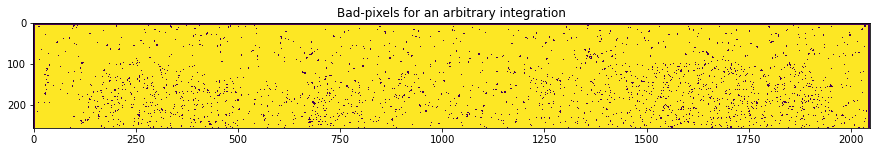

In [19]:
print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask_bcr) / (mask_bcr.shape[0] * mask_bcr.shape[1] * mask_bcr.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask_bcr[nint,:,:], interpolation='none')
plt.title('Bad-pixels for an arbitrary integration')
#plt.xlim([512,1536])

And correct the data (meaning replacing NaN values in data-frame with average of neighbouring pixels),

In [20]:
print('>>>> --- Correcting data...')
corrected_data = np.copy(gainscale_results.data)
corrected_data[mask_bcr == 0] = np.nan
for i in range(corrected_data.shape[0]):
    corrected_data[i,:,:] = utils.replace_nan(corrected_data[i,:,:])
print('>>>> --- Done!!')

>>>> --- Correcting data...
>>>> --- Done!!


And, finally, we will perform a row-by-row background subtraction:

In [21]:
corrected_data_bkg = np.ones(corrected_data.shape)
for i in tqdm(range(corrected_data.shape[0])):
    corrected_data_bkg[i,:,:], _ = reduce.polynomial_bkg_cols(corrected_data[i,:,:], mask=m1*mask_bcr[i,:,:], deg=1, sigma=5)

corrected_data_bkg1 = np.ones(corrected_data.shape)
for i in tqdm(range(corrected_data.shape[0])):
    corrected_data_bkg1[i,:,:], _ = reduce.row_by_row_bkg_sub(corrected_data_bkg[i,:,:], mask=m2*mask_bcr[i,:,:])

  0%|          | 0/9 [00:00<?, ?it/s]2023-10-24 20:07:31,721 - stpipe - WARNING - /Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)

100%|██████████| 9/9 [00:00<00:00, 36.25it/s]


Text(0, 0.5, 'Counts')

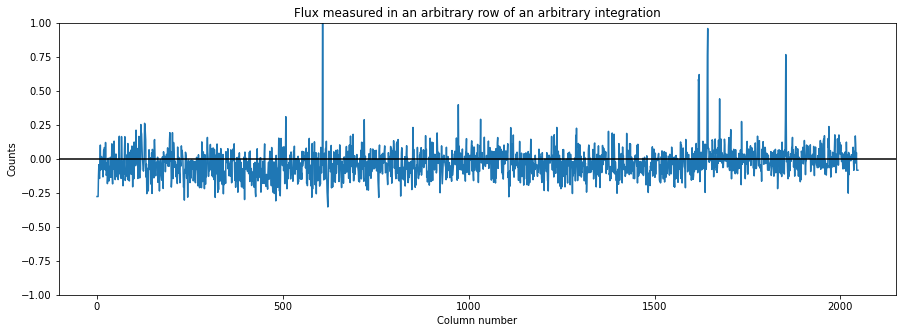

In [22]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg1[nint,100,:])
plt.ylim([-1,1])
plt.axhline(0., color='k')
plt.title('Flux measured in an arbitrary row of an arbitrary integration')
plt.xlabel('Column number')
plt.ylabel('Counts')

Text(0.5, 1.0, 'Flux level in an arbitrary column of an arbitrary integration')

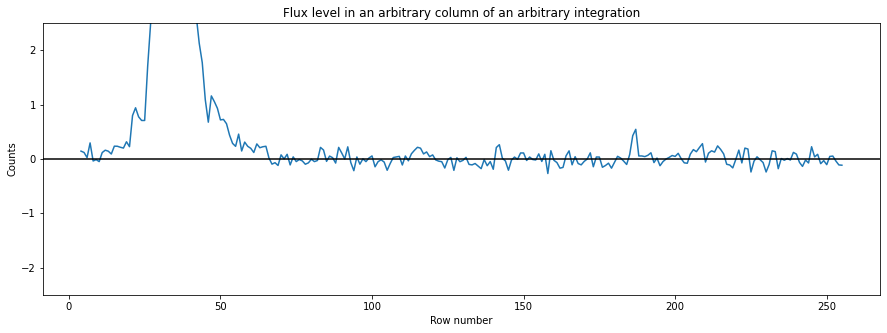

In [23]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg1[nint,:,500])
plt.ylim([-2.5,2.5])
plt.axhline(0., color='k')
plt.xlabel('Row number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary column of an arbitrary integration')

Saving the data,

In [24]:
np.save(pout + '/Corrected_data.npy', corrected_data_bkg1)
np.save(pout + '/Corrected_err.npy', corrected_errs)
np.save(pout + '/Mask_bcr.npy', mask_bcr)
np.save(pout + '/times.npy', times_bjd)